(70, 4)


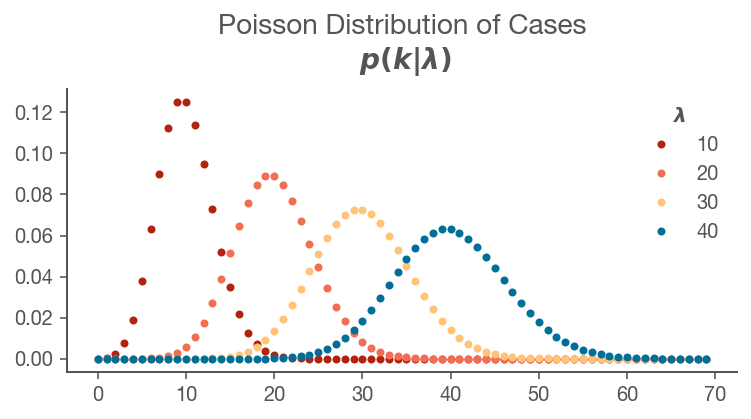

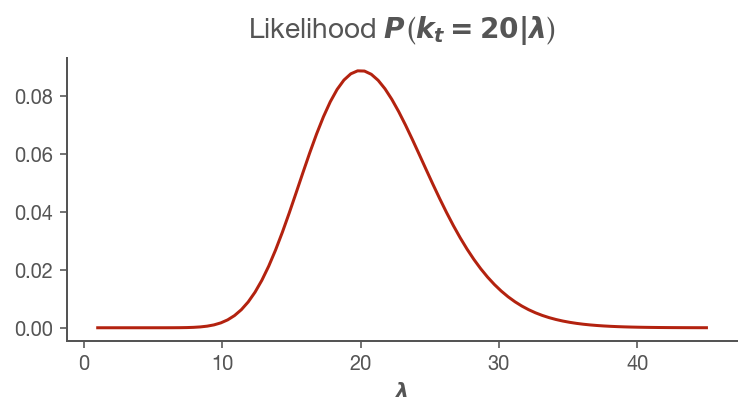

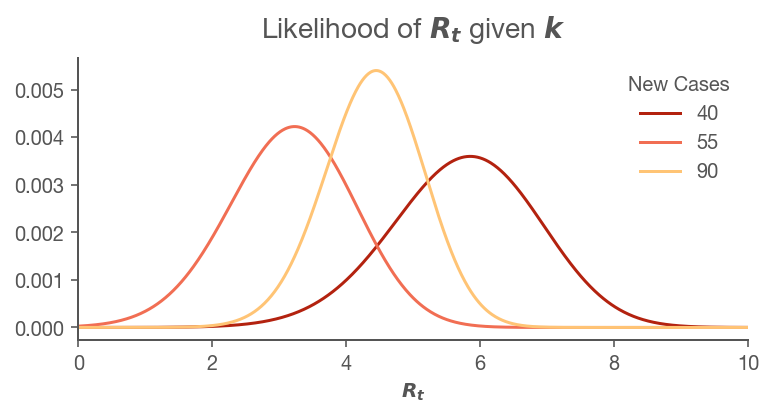

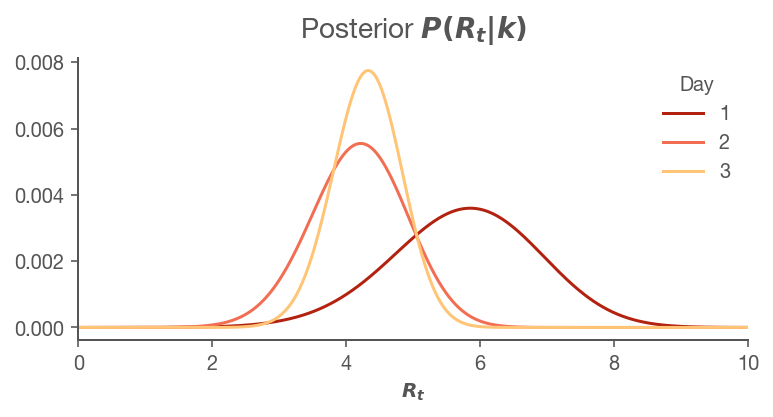

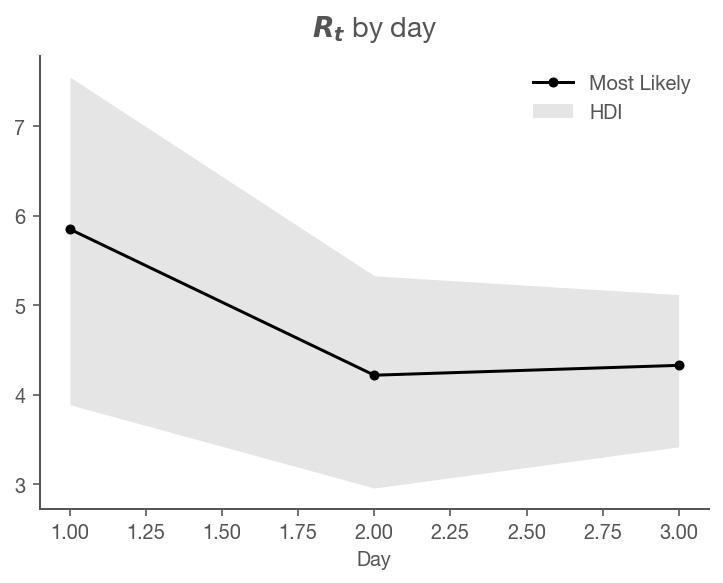

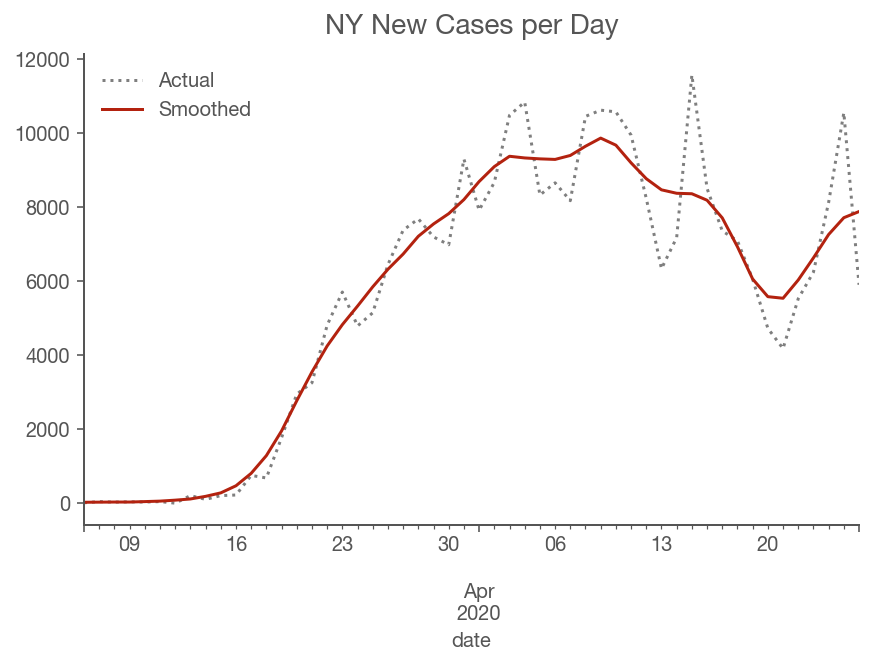

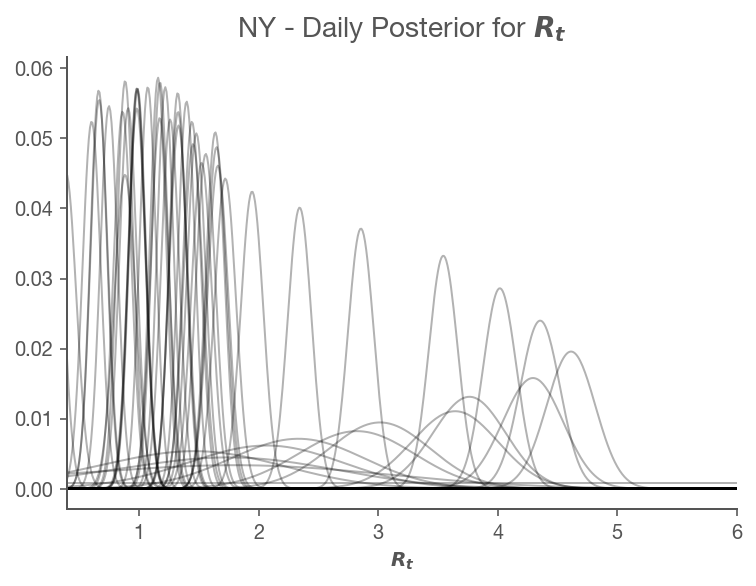

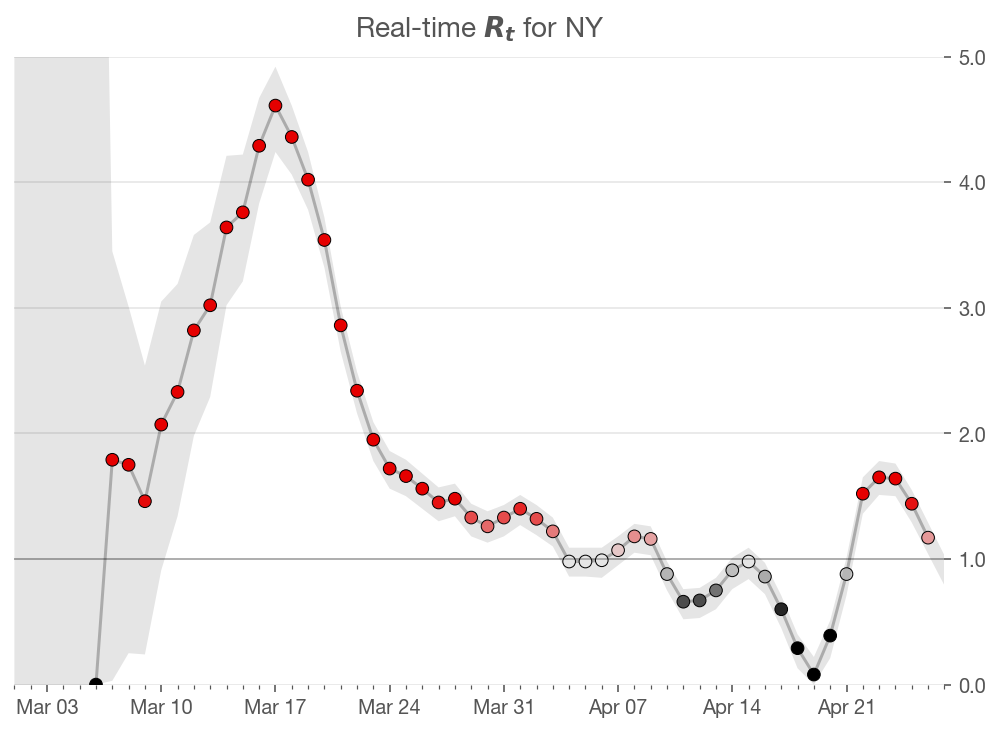

SystemExit: STOP MASTER US NOTEBOOK HERE!

/Users/schalk/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
%run 'Realtime R0.ipynb'
#import import_ipynb
#import RealtimeR0

In [3]:
import requests
import pandas as pd

#state_name = 'ZA'

### OLD API
## Last complete stats, one day delayed
#url = 'https://api.covid19api.com/total/dayone/country/' + state_name
## Current daily stats, last day might not have updated, if duplicated do not use
##url = 'https://api.covid19api.com/dayone/country/' + state_name

#client = requests.request("GET", url)
#response = client.text
#data_all = pd.read_json(response, orient='columns')
#data_all['Date'] = data_all['Date'].dt.tz_localize(None)
#data_index = data_all.set_index('Date')

## If delayed, manually add last day from another known source
#day = pd.DataFrame({'Confirmed':4220}, index=pd.to_datetime(['2020-04-24']))
#data_index = data_index.append(day)

#country = data_index['Confirmed']
#country

In [4]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
data_all = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

# single plot
state_name = 'total'

# current data set has empty total for last record
data_filter = data_all[:-1];
country = data_filter
country

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
0,2020-03-05,20200305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
1,2020-03-07,20200307,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN
2,2020-03-08,20200308,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
3,2020-03-09,20200309,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN
4,2020-03-11,20200311,0.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,NaN
5,2020-03-12,20200312,0.0,0.0,6.0,8.0,0.0,1.0,0.0,0.0,1.0,0.0,16.0,NaN
6,2020-03-13,20200313,0.0,0.0,10.0,10.0,0.0,1.0,0.0,0.0,3.0,0.0,24.0,NaN
7,2020-03-14,20200314,0.0,0.0,17.0,11.0,0.0,1.0,0.0,0.0,9.0,0.0,38.0,NaN
8,2020-03-15,20200315,0.0,0.0,24.0,12.0,0.0,1.0,0.0,0.0,14.0,0.0,51.0,NaN
9,2020-03-16,20200316,0.0,0.0,31.0,12.0,1.0,2.0,0.0,0.0,16.0,0.0,62.0,NaN


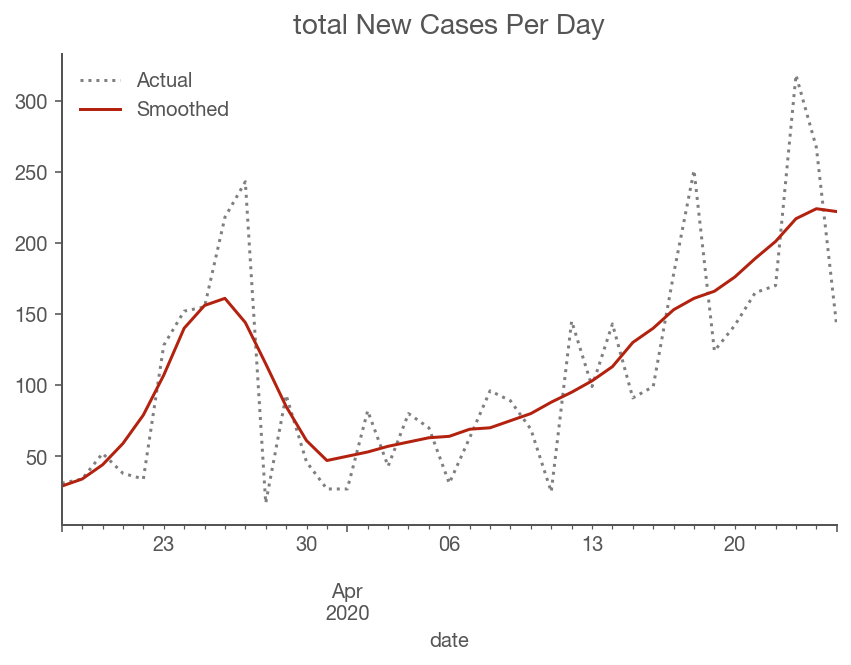

In [5]:
cases = pd.Series(country[state_name].values,index=country['date'])
original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases Per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

In [6]:
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

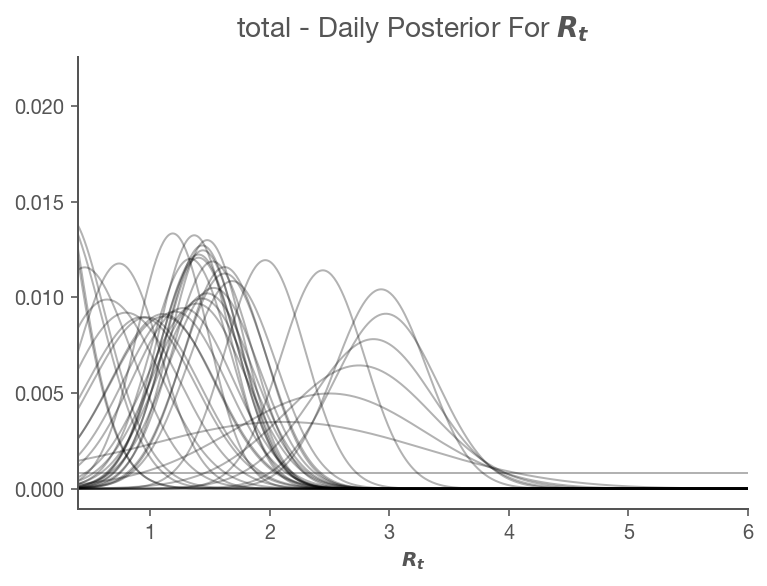

In [7]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior For $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [8]:
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result

,ML,Low_90,High_90
date,,,
2020-03-18,0.00,0.00,10.81
2020-03-19,2.11,0.22,3.70
2020-03-20,2.50,1.09,3.73
2020-03-21,2.75,1.67,3.71
2020-03-22,2.87,1.99,3.67
2020-03-23,2.97,2.20,3.64
2020-03-24,2.93,2.28,3.54
2020-03-25,2.44,1.85,3.00
2020-03-26,1.96,1.39,2.49


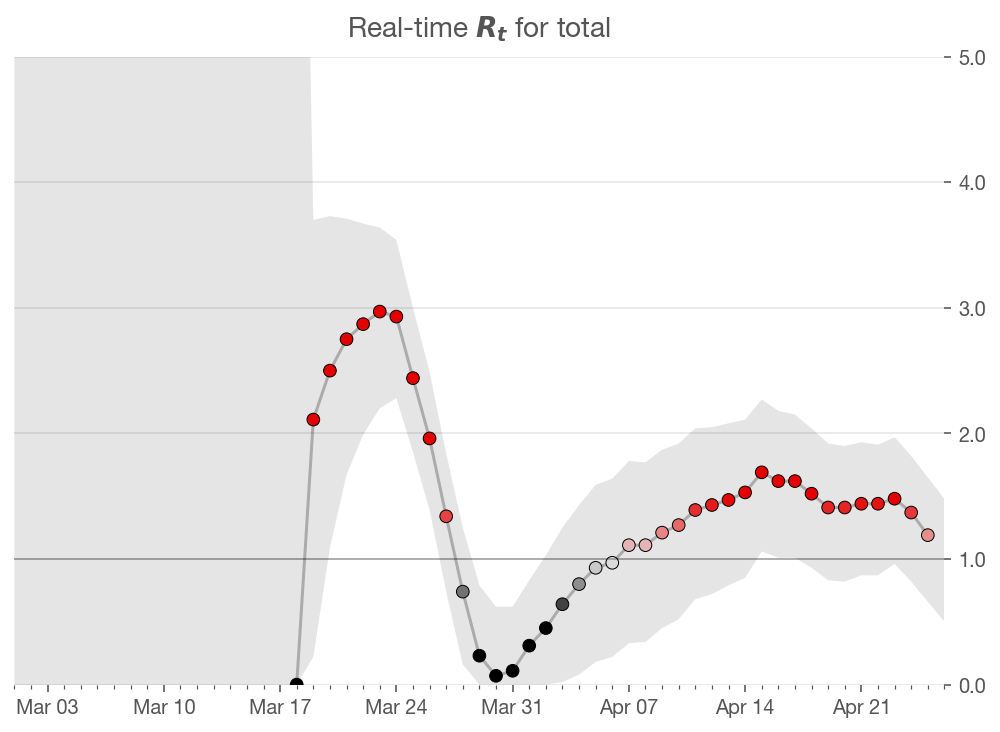

In [9]:
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))